In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import math
from textblob import TextBlob
# from better_profanity import profanity

# Nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\south\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\south\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\south\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\south\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# borrowed from stackoverflow https://stackoverflow.com/a/49146722
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def remove_unwanted(document):

    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove emoji's
    document = remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  ',"")
    
    return document.strip()

In [4]:
def lemmatize_text(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    
    lemmatized_sentence = " ".join(lemma_list)
    return lemmatized_sentence

In [5]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [6]:
data = pd.read_csv("Ukraine_emotions.csv")

exclusive_emotion = ["approval","desire","admiration","love","gratitude","excitement","optimism","joy","amusement","neutral"]
extracted_data = data.loc[~data["Emotion"].isin(exclusive_emotion)].reset_index()

extracted_data['tweet']=extracted_data['tweet'].astype(str)

text_corpus = extracted_data["tweet"].astype(str)
len(text_corpus)

834

In [7]:
text_corpus

0      @Caucasuswar Second strongest military in the ...
1      @systemkallops @IAPonomarenko Russia invaded U...
2      War crimes committed by invading #Russia|n for...
3      Learn now,be safe tomorrow:HAM radio is a grea...
4      The same people who are now the biggest suppor...
                             ...                        
829    Double Standard:\n.\nTwenty children are kille...
830    @LibertyHotelB @suddengunter @swl2861 @sentdef...
831    I just saw on the news where Russia bombed a t...
832    @Zak_Bagans Have you ever considered going to ...
833    Just posted on Twitter but I will not RT. \nTh...
Name: tweet, Length: 834, dtype: object

### This section is for expansion purpose

In [8]:
new_corpus = []

for text in text_corpus:

    clean_text = remove_unwanted(str(text))
    clean_text = ' '.join([w for w in clean_text.split() if len(w)>1])
    clean_text = lemmatize_text(clean_text)
    new_corpus.append(clean_text)

new_corpus = np.array(new_corpus)

In [9]:
new_corpus

array(['Caucasuswar Second strong military in the world or just second strong military in Ukraine',
       'systemkallops IAPonomarenko Russia invade Ukraine Putin be war criminal committing atrocity on innocent civilian Stop Putin Stand with Ukraine',
       'War crime commit by invade Russian force in Ukraine be just horrificThese be just several crime list by Ukraines Human Rights Ombundswoman Denisova',
       'Learn nowbe safe tomorrowHAM radio be great communication tool for Preppers NotificationsRex ManningFridayFeelingfridaymorningDaily Quordle 74JudgeWordle 293 XFridayVibesRepBXYankees Preppers Prepping Ukraine UkraineInvasion',
       'The same people who be now the big supporter of Ukraine be like wut be the holodomor',
       'cocotrolololo8 OwenJones84 Russian arm force need to be expel frm Ukraine by force a they have be defeat and expel from most of Ukraine so farYou disagree You think they shouldve be allow into Kiev to massacre and butcher pple at will Or do believe in

In [10]:
clean_tweet_data = np.array(new_corpus)
extracted_data["tweet"] = clean_tweet_data
extracted_data.to_csv('Ukraine_stressor.csv',index=False)

In [11]:
stop_words = stopwords.words('english')

extended_words = ["hes","ur","le","ta","tf","yo","couldnt","wasnt","along","ago","someone","literally","absolutely","probably","seem",
                  "hasnt","surround","though", "toward","suppose","ya","let","bc","great", "include","havent","joe","word","usa","twitter",
                  "donald","trump","trumps","hey","tomorrow","else","potus","via","ha",'wa', 'palestine', 'israel', 'ukraine', 'russia', 
                  'el', 'ti', 'nous', 'non', '2014', 'shit', 'middle','jordan', 'bien', 'azov', 'sind', 'wir', 'mariupol', 
                  'standwithukraine', 'africa4pal', 'ajapalestine', 'di', 'wird', 'israelis', 'ok', 'pakistan', 'cette', 'might', 
                  'tank', 'hell', 'auch', 'joe10616924', 'sloncycling4p', 'theres', 'begin', 'top', 'oh', 'um', 'comme', 'ich', 'saw', 
                  'head', 'israelpalestine', 'eye', 'sloncycling4pa1', 'ive', '2022', 'pink', 'little', 'daniel85401173', 'jamais', 
                  'zelenskyyua', 'peuple', 'sa', 'occupe', 'wie', 'allah', 'states', 'exactly', 'small',
                  'north', 'together', 'month', 'secblinken', 'billion', 'saoi', 'fr33palestine', 'hananyanaftali', 
                  'mehrmir', 'iam', 'probably', 'gomririam63', 'lapatina', 'hamas', 'buckeyericky', 'ppl', 'saudi', 
                  'britain', 'poland', 'either', 'already', 'traseas7', 'trussliz', 'enough', 'foramericans', 
                  'danielbfreeman3', 'ottoman', 'bc', 'palestineun', 'isreal', 'avimayer', 'liberate', 'bobbyshiskabob', 
                  'april', 'donaldhorwitz5', 'adilg0', 'canadianleb', 'joshpactor', 'samloyal23', 'theundefeated17', 
                  'ymg12345678', 'unhrc', 'free2smile1', 'jordaneesh', 'desuetudine', 'f0xyh0und', 'rookringer',
                  'fox640571', 'somalia', 'alasqa', 'bardot82', 'dublibtarian', 'rieznikg', 'emadmoussa', 'instead', 
                  'qasim', 'elswood3', 'missgrandia', 'besseder1', 'zafarhu58440496', 'lambawor', 'penbird', 'break',
                  'israelandstufff', 'israeli', 'jordan', 'syria', "ukraineworld", 'russian', 'putin', 'ukrainian', 'war', 
                  'weapon', 'ukrainerussia', 'russiaukraine', 'west', 'western', 'thewest', 'nazi']

stop_words.extend(extended_words)

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize,
                        max_features=500,
                        encoding='utf-8')

train_data = tfidf.fit_transform(new_corpus)


C:\Users\south\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names_out()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['courage', 'base', 'inflation', 'fuel', 'student', 'ursula', 'true', 'listen', 'obama', 'decide']


In [14]:
# Materialize the sparse data
data_dense = train_data.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.5532374100719424 %


## SAMPLE LDA

In [15]:
warnings.filterwarnings('ignore')
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations  
                                      random_state=100,          # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(train_data)

pprint(lda_model)  # Model attributes

LatentDirichletAllocation(n_components=20, n_jobs=-1, random_state=100)


In [16]:
avg_coherence = get_average_topic_coherence(train_data, lda_model.components_, 10)
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(train_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(train_data))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -20232.230345833646
Perplexity:  11247.132117656925
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## GridSearch LDA

In [17]:
# Define Search Parameters
topic_number = [5,10,15,20,25,30,35]
decay_rate = [0.5, 0.7, 0.9]
coherence_score = []
for i in topic_number:
    lda_model = LatentDirichletAllocation(n_components=i,          # Number of topics
                                        learning_decay= 0.7,       # Learning decay ratio
                                        max_iter=10,               # Max learning iterations  
                                        random_state=100,          # Random state
                                        evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                        n_jobs = -1,               # Use all available CPUs
                                        )
    lda_output = lda_model.fit_transform(train_data)
    coherence_score.append(get_average_topic_coherence(train_data, lda_model.components_, 25))
    print("LDA model with "+str(i)+" topics is done!")
        
coherence_score = np.array(coherence_score)

LDA model with 5 topics is done!
LDA model with 10 topics is done!
LDA model with 15 topics is done!
LDA model with 20 topics is done!
LDA model with 25 topics is done!
LDA model with 30 topics is done!
LDA model with 35 topics is done!


In [18]:
plotting_coherence = np.delete(coherence_score,0)
np.savetxt('coherence_score_with_lemma.out', coherence_score, delimiter=',')

In [19]:
plotting_coherence = np.loadtxt("coherence_score_with_lemma.out", dtype=float)

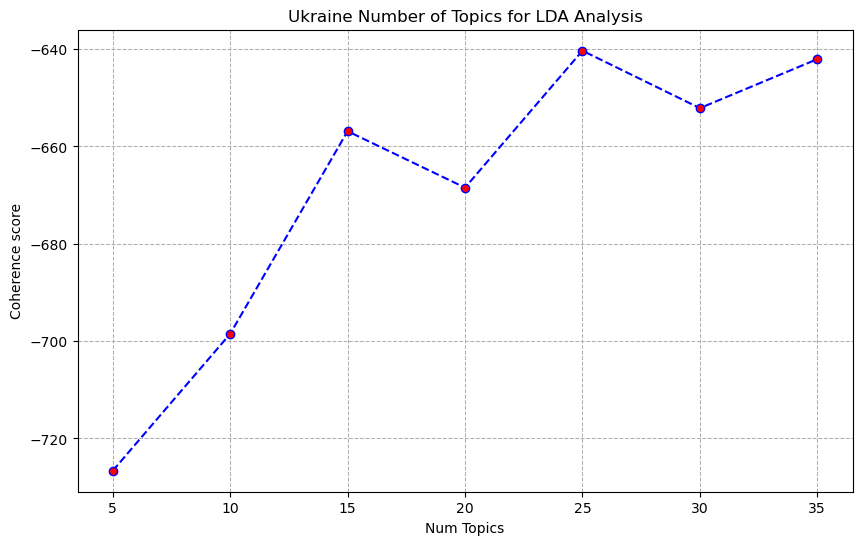

In [20]:
topics_no = [5,10,15,20,25,30,35]
plt.figure(figsize=(10,6))

plt.plot(topics_no,plotting_coherence, linestyle='--', marker='o', c='blue', mfc='red')
plt.title("Ukraine Number of Topics for LDA Analysis")
plt.xlabel("Num Topics")
plt.xticks([5,10,15,20,25,30,35])

plt.ylabel("Coherence score")
plt.grid(which ='major',linestyle='--', linewidth=0.75)
plt.show()

In [21]:
plt.savefig('Ukraine Number of Topics analysis.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

### LDA model with Optimal Topics number

In [22]:
topic_no = 5

In [23]:
lda_model = LatentDirichletAllocation(n_components=topic_no,            # Number of topics
                                    learning_decay= 0.7,
                                    max_iter=10,               # Max learning iterations  
                                    random_state=100,          # Random state
                                    evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                    n_jobs = -1,               # Use all available CPUs
                                    )
lda_output = lda_model.fit_transform(train_data)
pprint(lda_model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [24]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(train_data)

# column names
topicnames = ["Topic" + str(i) for i in range(topic_no)]

# index names
docnames = ["Doc" + str(i) for i in range(len(new_corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'white'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(30).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.080000,0.080000,0.590000,0.080000,0.170000,2
Doc1,0.060000,0.050000,0.290000,0.060000,0.540000,4
Doc2,0.060000,0.060000,0.160000,0.060000,0.660000,4
Doc3,0.660000,0.080000,0.090000,0.080000,0.080000,0
Doc4,0.080000,0.080000,0.700000,0.080000,0.080000,2
Doc5,0.050000,0.050000,0.050000,0.050000,0.800000,4
Doc6,0.560000,0.050000,0.280000,0.050000,0.050000,0
Doc7,0.060000,0.060000,0.060000,0.760000,0.060000,3
Doc8,0.140000,0.710000,0.050000,0.050000,0.050000,1
Doc9,0.060000,0.060000,0.420000,0.060000,0.410000,2


In [25]:
extracted_data["Topic_number"] = np.array(dominant_topic)
extracted_data.to_csv('Ukraine_stressor_with_topics.csv',index=False)


In [26]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,225
1,3,207
2,1,149
3,2,145
4,4,108


In [27]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()
lda_components = lda_model.components_
with open("Topic_term.txt", 'w') as f:
    for index, component in enumerate(lda_components):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        line = "Topic "+str(index)+": "+str([w for w in top_terms_list])
        # print(line)
        f.write(line)
        f.write('\n')

In [28]:
cluster_no = lda_model.n_components

# Construct the k-means clusters
clusters = KMeans(n_clusters=cluster_no, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.58  0.37  0.37  0.55  0.28]
 [-0.69  0.02 -0.01  0.72 -0.  ]]
Perc of Variance Explained: 
 [0.02 0.32]


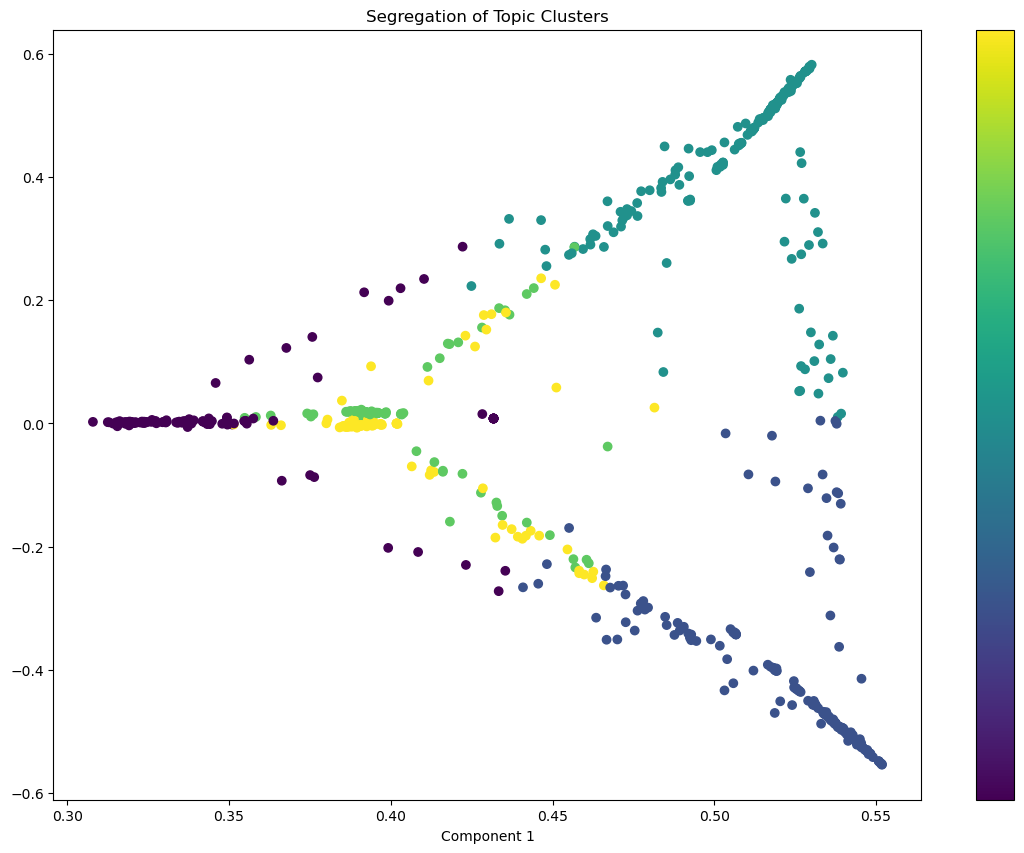

In [29]:
# Plot
plt.figure(figsize=(14, 10))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.colorbar(ticks=[])

In [30]:
import pyLDAvis.lda_model

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model,train_data,tfidf)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.157428 -0.022780       1        1  24.648466
0     -0.048292  0.083491       2        1  24.447565
2     -0.044838 -0.093468       3        1  18.169956
1     -0.065396 -0.051001       4        1  18.048304
4      0.001098  0.083759       5        1  14.685709, topic_info=        Term       Freq      Total Category  logprob  loglift
288  missile   9.000000   9.000000  Default  30.0000  30.0000
408  station   9.000000   9.000000  Default  29.0000  29.0000
23       amp  13.000000  13.000000  Default  28.0000  28.0000
37    attack  12.000000  12.000000  Default  27.0000  27.0000
443    train   8.000000   8.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
177      get   2.716714  12.339004   Topic5  -4.7643   0.4050
406    start   2.388420   7.589591   Topic5  -4.8931   0.7621
420  support   2.578113  14.010443   Topic5  -4.8167   0.2256
237     know   2.400011  12.167068   Topic5  -4.8883   0.2950
290     much   2.218407   7.270475   Topic5  -4.9669   0.7313

[281 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         3  0.439163        10
3         1  0.676991        50
3         4  0.225664        50
4         4  0.804756        51
5         3  0.715246      able
...     ...       ...       ...
491       3  0.745626     write
492       2  0.737292     wrong
497       2  0.971945     youre
499       3  0.383980  zelensky
499       5  0.383980  zelensky

[464 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])

In [32]:
pyLDAvis.save_html(vis, 'Ukraine_lda.html')

## Auxiliary Testing

In [33]:
# # Define the number of topics or components
num_components=10

# # Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# # Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# # Get Components 
lda_components=model.components_

In [34]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()

for index, component in enumerate(lda_components):
     zipped = zip(terms, component)
top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
top_terms_list=list(dict(top_terms_key).keys())
print("Topic "+str(index)+": ",top_terms_list)

Topic 9:  ['see', 'get', 'support', 'family', 'help', 'youre', 'go']


In [35]:
data.head(1)

,ids,date,user,replyCount,retweetCount,likeCount,lang,tweet,country,Emotion
0,1.510000e+18,2022-04-08 15:55:47+00:00,A_L_E_X_V_E_G_A,0,0,0,en,Ukraine war disruptions send food prices to th...,Ukraine,neutral
